### Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv('spam.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


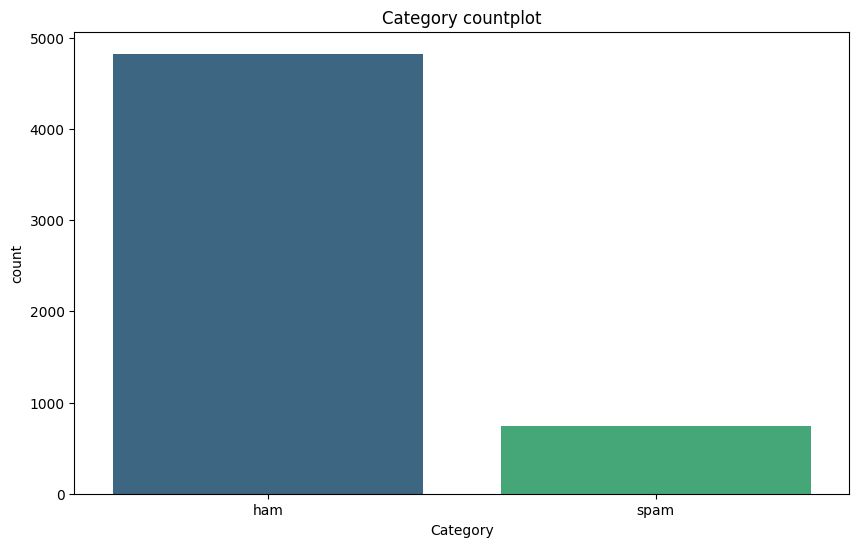

In [3]:
plt.figure(figsize=(10, 6))
plt.title('Category countplot')
sns.countplot(x=df['Category'], palette='viridis')
plt.show()

In [4]:
ham = df['Category'].value_counts('ham')  # values in percentages
ham

ham     0.865937
spam    0.134063
Name: Category, dtype: float64

In [5]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [6]:
X = df['Message']
y = df['Category']

### Model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [8]:
vectorize = TfidfVectorizer(stop_words='english')
X_vector_train = vectorize.fit_transform(X_train)
X_vector_test = vectorize.transform(X_test)

In [9]:
svc = SVC()

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10], 
              'kernel': ['rbf', 'linear', 'poly'], 
              'gamma': ['scale', 'auto']}

grid_model = GridSearchCV(svc, param_grid=param_grid)

grid_model.fit(X_vector_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']})

In [10]:
grid_model.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

In [11]:
y_pred = grid_model.predict(X_vector_test)

In [12]:
accuracy_score(y_test, y_pred)

0.9829596412556054

<AxesSubplot: >

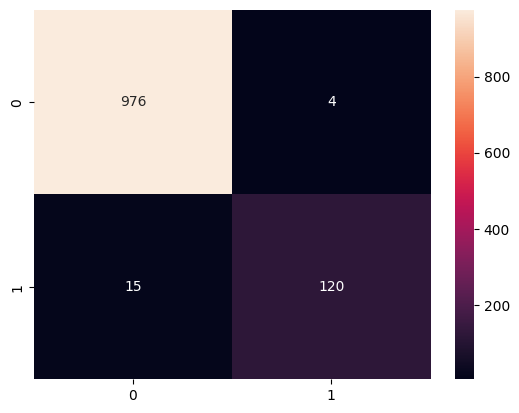

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       980
        spam       0.97      0.89      0.93       135

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



C:\Users\aga24\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


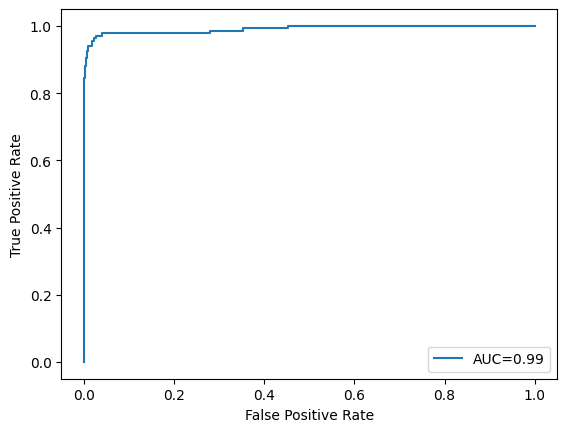

In [14]:
svc = SVC(C=10, gamma='scale', kernel='linear', probability=True)

y_test_1 = pd.get_dummies(y_test, drop_first=True)
y_train_1 = pd.get_dummies(y_train, drop_first=True)


svc.fit(X_vector_train, y_train_1)
y_pred_proba = svc.predict_proba(X_vector_test)[::,1]
fpr, tpr, _ = roc_curve(y_test_1,  y_pred_proba)
auc = round(roc_auc_score(y_test_1, y_pred_proba), 3)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Testing model by generated spam mail

In [37]:
text_spam = ["""Are you ready to win big? We have an incredible opportunity for you to win cash prizes ranging from 100 to 200,000 pounds!

To participate, simply text CASH11 to 87575. You will have six chances to win over the course of six days. Please note that each text message costs 150p/day and you must be 16 or older to participate. Terms and conditions apply.
"""]

In [90]:
# Now we are going to fit model using all data

vectorize = TfidfVectorizer(stop_words='english')
X_vector_scaler = vectorize.fit_transform(X)
new_X = vectorize.transform(text_spam)

In [98]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [58]:
svc = SVC(C=10, gamma='scale', kernel='linear', probability=True)
svc.fit(X_vector_scaler, y)

SVC(C=10, kernel='linear', probability=True)

In [79]:
prediction = svc.predict(new_X)
proba = svc.predict_proba(new_X)

print(f'Prediction: {prediction[0]}\nProba: {round(proba[0][1], 10)}')


Prediction: spam
Proba: 0.9999999192


In [114]:
dump(svc, 'spam_filter.joblib')  # Dump model

['spam_filter.joblib']

In [118]:
X.to_csv('X_to_vector.csv', index=False)  # Need to scale